# Email Spam Classifier 
##### [dataset download link](https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset/data)

In [1]:
# importing libraries

import os
import email
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt
#from sklearn.impute import SimpleImputer 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import learning_curve
from joblib import dump 

In [2]:
# read the csv file  
df = pd.read_csv("emails.csv")

#rename spam column to label
df = df.rename(columns={'spam': 'label'})

# shuffle the rows
df = shuffle(df, random_state=42)
df.head(10)

,text,label
4445,Subject: re : energy derivatives conference - ...,0
4118,"Subject: financial maths course , part 2 vinc...",0
3893,Subject: re : bullet points please respond to...,0
4210,"Subject: re : enron default swaps darrell , ...",0
5603,"Subject: re : power question steve , elena c...",0
561,Subject: all wraps around graand hello concet...,1
3761,Subject: allocations it is now official ! ! !...,0
4215,Subject: invitation to sunday dinner with vinc...,0
5596,"Subject: re : ming sit vince , thanks for th...",0
177,Subject: no further access to your account wil...,1


In [3]:
print("Dataset shape:", df.shape)
print("\nTotal email count: {}".format(len(df)))
print("Total labels: {}".format(len(df['label'])))

Dataset shape: (5728, 2)

Total email count: 5728
Total labels: 5728


In [4]:
# Label distribution and email length statistics
label_distribution = df['label'].value_counts()


# Add a 'length' feature
df['length'] = df['text'].str.len()
email_length_stats = df['length'].describe()


print("\nLabel distribution:\n", label_distribution)
print("\nMissing values:\n", df.isnull().sum())
print("\nEmail length statistics:\n", email_length_stats)            


Label distribution:
 label
0    4360
1    1368
Name: count, dtype: int64

Missing values:
 text      0
label     0
length    0
dtype: int64

Email length statistics:
 count     5728.000000
mean      1556.768680
std       2042.649812
min         13.000000
25%        508.750000
50%        979.000000
75%       1894.250000
max      43952.000000
Name: length, dtype: float64


### Exploratory Data Analysys (EDA)

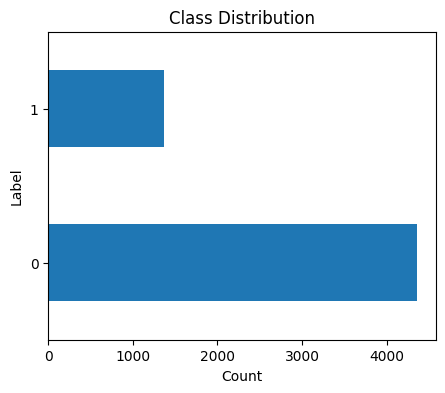

In [5]:
# Class distribution
plt.figure(figsize=(5, 4))
df['label'].value_counts().plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Label')
plt.show()

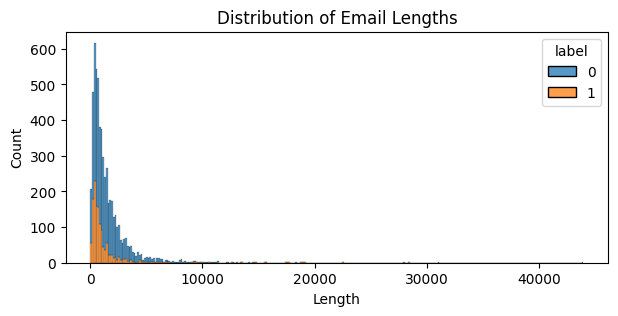

In [7]:
# Distribution of email lengths
plt.figure(figsize=(7, 3))
sns.histplot(data=df, x='length', hue='label', multiple='stack')
plt.title('Distribution of Email Lengths')
plt.xlabel('Length')
plt.show()

#### imbalanced dataset (needs to be taken care of)

### Data Preprocessing

In [9]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# # Handle missing values in 'length'
# imputer = SimpleImputer(strategy='mean')
# df['length'] = imputer.fit_transform(df'length')

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply text cleaning
df['Cleaned_email'] = df['text'].apply(clean_text)

# Display a few examples of cleaned email
print("\nExamples of cleaned email:")
print(df[['text', 'Cleaned_email']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Examples of cleaned email:
                                                   text  \
4445  Subject: re : energy derivatives conference - ...   
4118  Subject: financial maths course , part 2  vinc...   
3893  Subject: re : bullet points  please respond to...   
4210  Subject: re : enron default swaps  darrell ,  ...   
5603  Subject: re : power question  steve ,  elena c...   

                                          Cleaned_email  
4445  subject energy derivative conference may toron...  
4118  subject financial math course part vince case ...  
3893  subject bullet point please respond hi vince t...  
4210  subject enron default swap darrell sending tec...  
5603  subject power question steve elena chilkina gi...  


### Feature Engineering

In [10]:
# Split the data into features and target
X = df['Cleaned_email']
y = df['label']

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_email'])
y = df['label']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training dataset shape:", X_train.shape)
print("Resampled training dataset shape:", X_train_resampled.shape)
print("\nClass distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts(normalize=True))


Original training dataset shape: (4582, 5000)
Resampled training dataset shape: (6976, 5000)

Class distribution after SMOTE:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64


### Model Training & Evaluation

In [11]:
# function to train and evaluate model
def train_and_evaluate_model(model, X, y, model_name, cv=5, random_state=42):
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state), scoring='accuracy')
    print(f"{model_name} - Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    return scores.mean()

# List of models to try
models = [
    ('MultinomialNB', MultinomialNB()),
    ('RandomForest-100', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('RandomForest-200', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('RandomForest-300', RandomForestClassifier(n_estimators=300, random_state=42))
]

best_score = 0
best_model = None
best_model_name = ''

# looping through the models
for model_name, model in models:
    score = train_and_evaluate_model(model, X_train_resampled, y_train_resampled, model_name)
    
    if score > best_score:
        best_score = score
        best_model = model
        best_model_name = model_name

print(f"\nBest model: {best_model_name}")
print(f"Best cross-validation score: {best_score:.4f}")

MultinomialNB - Mean CV Accuracy: 0.9914 (+/- 0.0075)
RandomForest-100 - Mean CV Accuracy: 0.9924 (+/- 0.0036)
RandomForest-200 - Mean CV Accuracy: 0.9930 (+/- 0.0038)
RandomForest-300 - Mean CV Accuracy: 0.9930 (+/- 0.0037)

Best model: RandomForest-200
Best cross-validation score: 0.9930


In [12]:
# Train the final model on the entire resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Compare the model prediction accuracy on the resampled train and original test dataset
y_pred_train = best_model.predict(X_train_resampled)
y_pred_test = best_model.predict(X_test)

train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Train Accuracy: 1.0000
Test Accuracy: 0.9843

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       872
           1       0.97      0.96      0.97       274

    accuracy                           0.98      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.98      0.98      0.98      1146



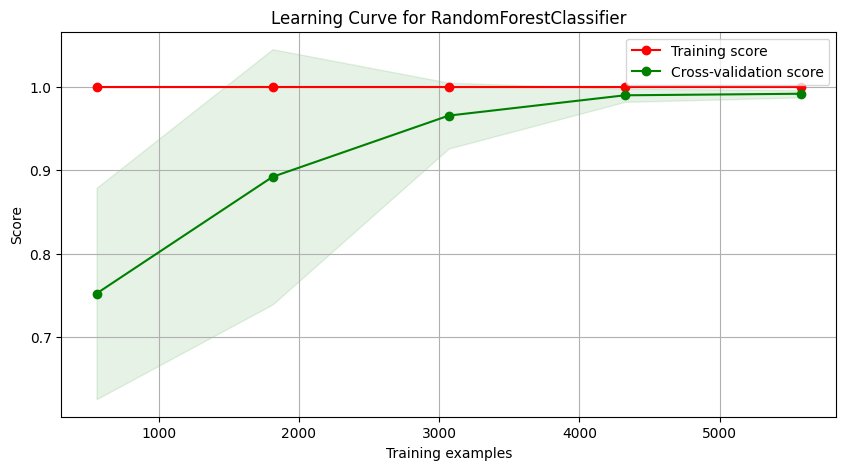

In [13]:
# Learning curve of the best_model 

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))
    
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")
    
    return plt

# Generate the learning curve
cv = 5  # number of folds in cross-validation
model_name = best_model.__class__.__name__  # Get the class name of the model
plt = plot_learning_curve(best_model, f"Learning Curve for {model_name}",
                          X_train_resampled, y_train_resampled, cv=cv, n_jobs=-1)

# Display the plot
plt.show()

#### The RandomForestClassifier with 200 n_estimators, performs best, with a mean CV accuracy of 99%, 97% f1_score at detecting spam.  <br> The Learning curve proves a good fit model.

### The Best model and vectorizer saved

In [14]:
# Save the best model, and vectorizer
model_filename = f'best_model_{best_model_name}.pkl'
dump(best_model, model_filename)
dump(vectorizer, 'tfidf_vectorizer.pkl')

print(f"Best model saved as {model_filename}")
print("TF-IDF vectorizer saved as: tfidf_vectorizer.pkl")

Best model saved as best_model_RandomForest-200.pkl
TF-IDF vectorizer saved as: tfidf_vectorizer.pkl


### Important information about the model and preprocessing saved

In [15]:
# Save important information about the model and preprocessing
import json

model_info = {
    'best_model_name': best_model_name,
    'best_cv_score': best_score,
    'test_accuracy': test_accuracy,
    'model_filename': model_filename,
    #  preprocessing info,
    'vectorizer_max_features': 5000, 
    'used_smote': True
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("Model information saved in 'model_info.json'")

Model information saved in 'model_info.json'
